In [1]:
import nemo.collections.asr as nemo_asr
import torch
import torch.nn.functional as F



In [2]:
import numpy as np
import os
import sys
import pandas as pd

In [3]:
vad_model.preprocessor

AudioToMFCCPreprocessor(
  (featurizer): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
)

In [30]:
#nemo_marblenet_preprocessor

file_path = '../SDH_DATA/검토필요_wav/전문 용어/202407171435_test_4a1187d7-165e-4556-b452-c81ca06cec82_DESKTOP-RGVCDB1.wav'
waveform, sample_rate = torchaudio.load(file_path, normalize=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
waveform = waveform.to(device)
length_tensor = torch.tensor([waveform.shape[1]], dtype=torch.float32).to(device)
nemo_mfcc, seq_len = vad_model.preprocessor.get_features(input_signal=waveform, length = length_tensor)

print(nemo_mfcc, seq_len)
print(nemo_mfcc.shape, seq_len.shape)
print(output.shape)


tensor([[[-6.3485e+01, -6.2135e+01, -6.0120e+01,  ..., -6.7233e+01,
          -6.7154e+01, -6.5580e+01],
         [ 1.1759e+01,  1.3661e+01,  1.0217e+01,  ...,  1.5184e+01,
           1.6963e+01,  1.7073e+01],
         [ 6.9238e+00,  7.4444e+00,  7.1438e+00,  ...,  2.9296e+00,
           2.9059e+00, -4.7158e-01],
         ...,
         [-6.3982e-01,  5.6056e-01, -2.7611e-01,  ...,  1.3411e-01,
          -5.5370e-02,  1.9848e-01],
         [-5.1088e-01, -5.3749e-01,  4.6409e-01,  ...,  1.3685e-02,
          -8.1588e-01,  3.4275e-01],
         [-2.6860e-01,  1.0855e-01, -2.3538e-02,  ..., -1.1273e-01,
           1.6927e-01,  1.3751e-02]]], device='cuda:0') tensor([325], device='cuda:0')
torch.Size([1, 64, 326]) torch.Size([1])
torch.Size([1, 64, 52000])


In [3]:
vad_model = nemo_asr.models.EncDecClassificationModel.load_from_checkpoint(checkpoint_path='../nemo_experiments/marblenet/2024-08-02_09-39-12/checkpoints/marblenet--val_loss=0.0101-epoch=35.ckpt')
vad_model.eval()
vad_model.to('cuda')
preprocessor = vad_model.preprocessor

[NeMo W 2024-08-12 10:55:13 nemo_logging:393] c:\Users\conta\anaconda3\envs\marblenet\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [5]:
vad_model.export('dcai_vad.onnx', input_example=(torch.rand(1,64,8201).to('cuda'),), dynamic_axes={
                     'audio_signal': {0: 'batch_size', 2: 'input_signal_length'}, 
                     'logits': {0: 'batch_size'}})

[NeMo W 2024-08-06 17:28:27 nemo_logging:393] Turned off 20 masked convolutions
[NeMo W 2024-08-06 17:28:27 nemo_logging:393] c:\Users\conta\anaconda3\envs\marblenet\Lib\site-packages\nemo\collections\asr\modules\conv_asr.py:213: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
      if seq_length > self.max_audio_length:
    


[NeMo I 2024-08-06 17:28:27 nemo_logging:381] Successfully exported EncDecClassificationModel to dcai_vad.onnx


(['dcai_vad.onnx'],
 ['nemo.collections.asr.models.classification_models.EncDecClassificationModel exported to ExportFormat.ONNX'])

In [5]:
vad_model.export('dcai_vad.onnx', dynamic_axes={
                     'audio_signal': {0: 'batch_size', 2: 'input_signal_length'}, 
                     'logits': {0: 'batch_size'}}, onnx_opset_version=17)

[NeMo W 2024-08-07 17:14:40 nemo_logging:393] Turned off 20 masked convolutions
[NeMo W 2024-08-07 17:14:41 nemo_logging:393] c:\Users\conta\anaconda3\envs\marblenet\Lib\site-packages\nemo\collections\asr\modules\conv_asr.py:213: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
      if seq_length > self.max_audio_length:
    


[NeMo I 2024-08-07 17:14:41 nemo_logging:381] Successfully exported EncDecClassificationModel to dcai_vad.onnx


(['dcai_vad.onnx'],
 ['nemo.collections.asr.models.classification_models.EncDecClassificationModel exported to ExportFormat.ONNX'])

In [147]:
#by torch.stft

import torch
import torch.nn as nn
import torchaudio
import math

class MFCCTransform(nn.Module):
    def __init__(self, sr=16000, n_mfcc=64, n_mels=64, n_fft=512, window_len=400, hop_length=160):
        super(MFCCTransform, self).__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window_len = window_len

        self.window = torch.hann_window(self.window_len)
        self.mel_filterbank = torchaudio.transforms.MelScale(
            n_mels=n_mels, 
            sample_rate=sr, 
            f_max=sr // 2, 
            n_stft=n_fft // 2 + 1
        )
        self.dct = self.create_dct(n_mfcc, n_mels)

    def create_dct(self, n_mfcc, n_mels):
        dct_matrix = torch.zeros(n_mfcc, n_mels)
        for k in range(n_mfcc):
            dct_matrix[k] = math.sqrt(2.0 / n_mels) * torch.cos(
                k * math.pi * (torch.arange(n_mels) + 0.5) / n_mels
            )
        dct_matrix[0] *= 1.0 / math.sqrt(2.0)
        return dct_matrix

    def forward(self, waveform):
        device = waveform.device
        batch_size, num_channels, num_samples = waveform.size()

        # Ensure window is on the same device as the waveform
        window = self.window.to(device)

        # Reshape waveform to 2D tensor (batch_size * num_channels, num_samples)
        waveform = waveform.view(batch_size * num_channels, num_samples)
        
        # Compute the STFT
        stft = torch.stft(
            waveform, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.window_len, 
            window=window, 
            return_complex=False,
            normalized=True,
            pad_mode='constant'
            

        )
        magnitude = stft.pow(2).sum(-1).sqrt()  # Compute magnitude

        # Apply mel filterbanks
        mel_spectrogram = self.mel_filterbank(magnitude)


        # Compute log mel spectrogram
        log_mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

        # Compute MFCC
        mfcc = torch.matmul(self.dct.to(log_mel_spectrogram.device), log_mel_spectrogram)

        return mfcc

# Instantiate the model
model = MFCCTransform()

# Load the waveform and sample_rate using torchaudio
waveform, sample_rate = torchaudio.load(
    '../SDH_DATA/검토필요_wav/전문 용어/202407171435_test_4a1187d7-165e-4556-b452-c81ca06cec82_DESKTOP-RGVCDB1.wav', 
    normalize=True
)

# Add batch dimension to the waveform
waveform = waveform.unsqueeze(0)  # shape: (1, num_channels, num_samples)

# Ensure waveform is in the correct format for the model
if waveform.dim() == 2:  # mono channel
    waveform = waveform.unsqueeze(1)  # shape: (batch_size, num_channels, num_samples)

# Check model output
output = model(waveform)
print(f"MFCC shape: {output.shape}")
print(output)  # Ensure the output shape is correct

# Export the model to ONNX
torch.onnx.export(
    model,                      # model being run
    waveform,                   # model input (or a tuple for multiple inputs)
    "dcai_preprocessor.onnx",   # where to save the model (can be a file or file-like object)
    export_params=True,         # store the trained parameter weights inside the model file
    opset_version=17,           # the ONNX version to export the model to
    do_constant_folding=True,   # whether to execute constant folding for optimization
    input_names=["waveform"],   # the model's input names
    output_names=["audio_signal"],    # the model's output names
    dynamic_axes={
        'waveform': {0: 'batch_size', 2: 'audio_length'},    # variable length axes
        'audio_signal': {0: 'batch_size', 2: 'input_signal_length'}
    }
)

print("Model has been converted to ONNX format and saved as 'dcai_preprocessor.onnx'.")


[NeMo W 2024-08-07 10:54:50 nemo_logging:393] c:\Users\conta\anaconda3\envs\marblenet\Lib\site-packages\torch\onnx\utils.py:739: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
      _C._jit_pass_onnx_graph_shape_type_inference(
    
[NeMo W 2024-08-07 10:54:50 nemo_logging:393] c:\Users\conta\anaconda3\envs\marblenet\Lib\site-packages\torch\onnx\utils.py:1244: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
      _C._jit_pass_onnx_graph_shape_type_inference(
    


MFCC shape: torch.Size([1, 64, 326])
tensor([[[-5.0910e+01, -5.2038e+01, -5.1024e+01,  ..., -5.4776e+01,
          -5.4724e+01, -5.3355e+01],
         [ 1.8584e+00,  4.3161e+00,  2.4604e+00,  ...,  4.9197e+00,
           5.9640e+00,  4.4157e+00],
         [ 1.5207e+00,  3.7187e+00,  3.5653e+00,  ...,  1.3610e+00,
           1.5139e+00, -1.8666e-01],
         ...,
         [-2.6478e-02,  2.9625e-01, -8.2023e-02,  ...,  1.2236e-01,
          -8.3635e-02, -7.2653e-02],
         [-1.3527e-01, -2.8493e-01,  2.2697e-01,  ...,  1.1071e-02,
          -4.2740e-01, -7.6594e-02],
         [ 1.7398e-01,  9.5491e-02, -2.8077e-02,  ..., -9.6728e-02,
           1.2388e-01,  1.9994e-01]]])
Model has been converted to ONNX format and saved as 'dcai_preprocessor.onnx'.


In [290]:
stft1 = torch.stft(
            waveform[0], 
            n_fft=512, 
            hop_length=160, 
            win_length=400, 
            window=torch.hann_window(400), 
            pad_mode='reflect',
            center=True,
            return_complex=True
            )
print(stft1)

# print(stft)

tensor([[[-1.0377e-01+0.0000e+00j, -1.4791e-02+0.0000e+00j,
          -7.2661e-02+0.0000e+00j,  ...,
          -5.1439e-02+0.0000e+00j, -1.4109e-01+0.0000e+00j,
           2.9749e-01+0.0000e+00j],
         [-5.5717e-02+3.0324e-08j,  3.4989e-02+2.2961e-01j,
           1.9869e-01-1.1900e-01j,  ...,
           1.6106e-02-1.2836e-01j,  1.5855e-01+1.3759e-01j,
          -2.8013e-01-3.5253e-03j],
         [ 2.4987e-01-9.9368e-09j, -8.7330e-02-4.0203e-01j,
          -3.8562e-01+1.7119e-01j,  ...,
           6.9258e-04+1.6449e-01j, -1.6984e-01-8.9358e-02j,
           1.5569e-01+1.2339e-03j],
         ...,
         [-2.5523e-03+4.8058e-09j,  1.3816e-03+5.2549e-04j,
          -1.2275e-03+1.2137e-03j,  ...,
           2.2421e-04-4.4969e-05j,  1.5221e-04-2.7155e-04j,
           9.6386e-06-2.0714e-06j],
         [ 3.3823e-03+5.3558e-10j, -5.8005e-04-4.7986e-04j,
           1.0364e-03-3.9376e-04j,  ...,
          -3.7350e-04-2.7553e-05j, -1.3326e-04+2.4113e-04j,
           1.7124e-04+7.9461e-08j],
 

In [33]:
#최종

import torch
import torch.nn as nn
import torchaudio
import math

class MFCCTransform(nn.Module):
    def __init__(self, sr=16000, n_mfcc=64, n_mels=64, n_fft=512, window_len=400, hop_length=160):
        super(MFCCTransform, self).__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.n_stft = n_fft // 2 + 1
        self.hop_length = hop_length
        self.window_len = window_len

        self.window = torch.hann_window(self.window_len)
        self.mel_filterbank = torchaudio.transforms.MelScale(
            n_mels=n_mels, 
            sample_rate=sr,
            f_min= 0.0, 
            f_max= None,
            n_stft=self.n_stft,
            norm=None,
            mel_scale="htk", 
        )
        self.dct = self.create_dct(n_mfcc, n_mels)

    def create_dct(self, n_mfcc, n_mels):
        dct_matrix = torch.zeros(n_mfcc, n_mels)
        for k in range(n_mfcc):
            dct_matrix[k] = math.sqrt(2.0 / n_mels) * torch.cos(
                k * math.pi * (torch.arange(n_mels) + 0.5) / n_mels
            )
        dct_matrix[0] *= 1.0 / math.sqrt(2.0)
        return dct_matrix

    def forward(self, waveform):
        device = waveform.device
        batch_size, num_channels, num_samples = waveform.size()

        # Ensure window is on the same device as the waveform
        window = self.window.to(device)

        shape = waveform.size()
        waveform = waveform.reshape(-1, shape[-1])

        # Reshape waveform to 2D tensor (batch_size * num_channels, num_samples)
        # waveform = waveform.view(batch_size * num_channels, num_samples)
        
        # Compute the STFT
        stft = STFT( 
            filter_length=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.window_len, 
            window='hann',
            normalized=False

        )

        stft = stft(waveform)
        # print(stft)

        stft=stft.reshape(shape[:-1] + stft.shape[-2:])
        magnitude = stft.abs().pow(2) # Compute magnitude

        # Apply mel filterbanks
        mel_spectrogram = self.mel_filterbank(magnitude)


        # Compute log mel spectrogram
        log_mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

        # Compute MFCC
        mfcc = torch.matmul(self.dct.to(log_mel_spectrogram.device), log_mel_spectrogram)
        mfcc = mfcc.squeeze(0)

        return mfcc

# Instantiate the model
model = MFCCTransform()

# Load the waveform and sample_rate using torchaudio
waveform, sample_rate = torchaudio.load(
    '../SDH_DATA/검토필요_wav/전문 용어/202407171435_test_4a1187d7-165e-4556-b452-c81ca06cec82_DESKTOP-RGVCDB1.wav', 
    normalize=True
)

# Add batch dimension to the waveform
waveform = waveform.unsqueeze(0)  # shape: (1, num_channels, num_samples)

# Ensure waveform is in the correct format for the model
if waveform.dim() == 2:  # mono channel
    waveform = waveform.unsqueeze(1)  # shape: (batch_size, num_channels, num_samples)

# Check model output
output = model(waveform)
print(f"MFCC shape: {output.shape}")
print(output.shape)  # Ensure the output shape is correct
print(nemo_mfcc)
# Export the model to ONNX
torch.onnx.register_custom_op_symbolic("aten::lift_fresh", lambda g, x: x, 13)
torch.onnx.export(
    model,                      # model being run
    waveform,                   # model input (or a tuple for multiple inputs)
    "dcai_preprocessor.onnx",   # where to save the model (can be a file or file-like object)
    export_params=True,         # store the trained parameter weights inside the model file
    opset_version=17,           # the ONNX version to export the model to
    do_constant_folding=True,   # whether to execute constant folding for optimization
    input_names=["waveform"],   # the model's input names
    output_names=["signal"],    # the model's output names
    dynamic_axes={
        'waveform': {0: 'batch_size', 2: 'audio_length'},    # variable length axes
        'signal': {0: 'batch_size', 2: 'signal_length'}
    }
)

print("Model has been converted to ONNX format and saved as 'dcai_preprocessor.onnx'.")


[NeMo W 2024-08-12 11:20:02 nemo_logging:393] C:\Users\conta\AppData\Local\Temp\ipykernel_27620\2670011197.py:31: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
      fft_window = torch.from_numpy(fft_window).float()
    


MFCC shape: torch.Size([1, 64, 326])
torch.Size([1, 64, 326])
tensor([[[-6.3485e+01, -6.2135e+01, -6.0120e+01,  ..., -6.7233e+01,
          -6.7154e+01, -6.5580e+01],
         [ 1.1759e+01,  1.3661e+01,  1.0217e+01,  ...,  1.5184e+01,
           1.6963e+01,  1.7073e+01],
         [ 6.9238e+00,  7.4444e+00,  7.1438e+00,  ...,  2.9296e+00,
           2.9059e+00, -4.7158e-01],
         ...,
         [-6.3982e-01,  5.6056e-01, -2.7611e-01,  ...,  1.3411e-01,
          -5.5370e-02,  1.9848e-01],
         [-5.1088e-01, -5.3749e-01,  4.6409e-01,  ...,  1.3685e-02,
          -8.1588e-01,  3.4275e-01],
         [-2.6860e-01,  1.0855e-01, -2.3538e-02,  ..., -1.1273e-01,
           1.6927e-01,  1.3751e-02]]], device='cuda:0')
Model has been converted to ONNX format and saved as 'dcai_preprocessor.onnx'.


In [45]:
import torch
import torch.nn as nn
import torchaudio
import math

class MFCCTransform(nn.Module):
    def __init__(self, sr=16000, n_mfcc=64, n_mels=64, n_fft=512, window_len=400, hop_length=160):
        super(MFCCTransform, self).__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.n_stft = n_fft // 2 + 1
        self.hop_length = hop_length
        self.window_len = window_len

        self.window = torch.hann_window(self.window_len)
        self.mel_filterbank = torchaudio.transforms.MelScale(
            n_mels=n_mels, 
            sample_rate=sr,
            f_min= 0.0, 
            f_max= None,
            n_stft=self.n_stft,
            norm=None,
            mel_scale="htk", 
        )
        self.dct = self.create_dct(n_mfcc, n_mels)

    def create_dct(self, n_mfcc, n_mels):
        dct_matrix = torch.zeros(n_mfcc, n_mels)
        for k in range(n_mfcc):
            dct_matrix[k] = math.sqrt(2.0 / n_mels) * torch.cos(
                k * math.pi * (torch.arange(n_mels) + 0.5) / n_mels
            )
        dct_matrix[0] *= 1.0 / math.sqrt(2.0)
        return dct_matrix

    def forward(self, waveform):
        print(f"Initial waveform shape: {waveform.shape}")
        
        device = waveform.device
        batch_size, num_channels, num_samples = waveform.size()

        # Ensure window is on the same device as the waveform
        window = self.window.to(device)

        shape = waveform.size()
        waveform = waveform.reshape(-1, shape[-1])
        print(f"Reshaped waveform shape: {waveform.shape}")

        # Compute the STFT
        stft = STFT( 
            filter_length=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.window_len, 
            window='hann',
            normalized=False
        )

        stft = stft(waveform)
        print(f"STFT output shape: {stft.shape}")

        stft = stft.reshape(shape[:-1] + stft.shape[-2:])
        print(f"Reshaped STFT shape: {stft.shape}")
        
        magnitude = stft.abs().pow(2)  # Compute magnitude
        print(f"Magnitude shape: {magnitude.shape}")

        # Apply mel filterbanks
        mel_spectrogram = self.mel_filterbank(magnitude)
        print(f"Mel spectrogram shape: {mel_spectrogram.shape}")

        # Compute log mel spectrogram
        log_mel_spectrogram = torch.log(mel_spectrogram + 1e-6)
        print(f"Log mel spectrogram shape: {log_mel_spectrogram.shape}")

        # Compute MFCC
        mfcc = torch.matmul(self.dct.to(log_mel_spectrogram.device), log_mel_spectrogram)
        mfcc = mfcc.squeeze(0)
        print(f"Final MFCC shape: {mfcc.shape}")

        return mfcc

# Instantiate the model
model = MFCCTransform()

# Load the waveform and sample_rate using torchaudio
waveform, sample_rate = torchaudio.load(
    '../SDH_DATA/검토필요_wav/전문 용어/202407171435_test_4a1187d7-165e-4556-b452-c81ca06cec82_DESKTOP-RGVCDB1.wav', 
    normalize=True
)

print(f"Loaded waveform shape: {waveform.shape}, Sample rate: {sample_rate}")

# Add batch dimension to the waveform
waveform = waveform.unsqueeze(0)  # shape: (1, num_channels, num_samples)
print(f"Waveform shape after unsqueeze: {waveform.shape}")

# Ensure waveform is in the correct format for the model
if waveform.dim() == 2:  # mono channel
    waveform = waveform.unsqueeze(1)  # shape: (batch_size, num_channels, num_samples)
print(f"Waveform shape after second unsqueeze (if applied): {waveform.shape}")

# Check model output
output = model(waveform)
print(f"MFCC shape: {output.shape}")
print(output)  # Ensure the output shape is correct

# Export the model to ONNX
torch.onnx.register_custom_op_symbolic("aten::lift_fresh", lambda g, x: x, 13)
torch.onnx.export(
    model,                      # model being run
    waveform,                   # model input (or a tuple for multiple inputs)
    "dcai_preprocessor_v3.onnx",   # where to save the model (can be a file or file-like object)
    export_params=True,         # store the trained parameter weights inside the model file
    opset_version=17,           # the ONNX version to export the model to
    do_constant_folding=True,   # whether to execute constant folding for optimization
    input_names=["waveform"],   # the model's input names
    output_names=["signal"],    # the model's output names
    dynamic_axes={
        'waveform': {0: 'batch_size', 2: 'audio_length'},    # variable length axes
        'signal': {0: 'batch_size', 2: 'signal_length'}
    }
)

print("Model has been converted to ONNX format and saved as 'dcai_preprocessor.onnx_v3'.")


[NeMo W 2024-08-12 12:36:19 nemo_logging:393] C:\Users\conta\AppData\Local\Temp\ipykernel_27620\2670011197.py:31: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
      fft_window = torch.from_numpy(fft_window).float()
    


Loaded waveform shape: torch.Size([1, 52000]), Sample rate: 16000
Waveform shape after unsqueeze: torch.Size([1, 1, 52000])
Waveform shape after second unsqueeze (if applied): torch.Size([1, 1, 52000])
Initial waveform shape: torch.Size([1, 1, 52000])
Reshaped waveform shape: torch.Size([1, 52000])
STFT output shape: torch.Size([1, 257, 326])
Reshaped STFT shape: torch.Size([1, 1, 257, 326])
Magnitude shape: torch.Size([1, 1, 257, 326])
Mel spectrogram shape: torch.Size([1, 1, 64, 326])
Log mel spectrogram shape: torch.Size([1, 1, 64, 326])
Final MFCC shape: torch.Size([1, 64, 326])
MFCC shape: torch.Size([1, 64, 326])
tensor([[[-6.3485e+01, -6.2135e+01, -6.0120e+01,  ..., -6.7233e+01,
          -6.7154e+01, -6.5580e+01],
         [ 1.1759e+01,  1.3661e+01,  1.0217e+01,  ...,  1.5184e+01,
           1.6963e+01,  1.7073e+01],
         [ 6.9238e+00,  7.4444e+00,  7.1438e+00,  ...,  2.9296e+00,
           2.9059e+00, -4.7158e-01],
         ...,
         [-6.3981e-01,  5.6057e-01, -2.7610e

In [44]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny

class STFT(torch.nn.Module):
    def __init__(self, filter_length=512, hop_length=160, win_length=400,
                window='hann', normalized = True):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        fourier_basis = np.fft.fft(np.eye(self.filter_length))
        self.normalized = normalized
        
        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())


    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude =  torch.sqrt(real_part ** 2 + imag_part ** 2)
        if self.normalized:
            magnitude /= (self.filter_length ** 0.5)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase
    
    # def forward(self, input_data):
    #     magnitude, phase = self.transform(input_data)

    #     # Interpolate the magnitude to match the original audio length
    #     original_length = input_data.size(-1)
    #     magnitude = F.interpolate(magnitude, size=original_length, mode='linear', align_corners=False)

    #     return magnitude


    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        return self.magnitude
    
    

In [42]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny

class STFT(torch.nn.Module):
    def __init__(self, filter_length=512, hop_length=160, win_length=400,
                window='hann', normalized = True):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        fourier_basis = np.fft.fft(np.eye(self.filter_length))
        self.normalized = normalized

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())


    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude =real_part+imag_part
        if self.normalized:
            magnitude /= (self.filter_length ** 0.5)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase


    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        return self.magnitude

In [162]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny



class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=512, hop_length=160, win_length=400,
                 window='hann', normalized = True):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        fourier_basis = np.fft.fft(np.eye(self.filter_length))
        self.normalized = normalized

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())


    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.complex(real_part,imag_part)
        if self.normalized:
            magnitude /= (self.filter_length ** 0.5)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase


    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        return self.magnitude
    
    def reshape(self, tensor, shape):
        return tensor.reshape(shape)
    

In [404]:
stft_module = STFT()
sample_rate = 16000
duration = 1
t = torch.linspace(0, duration, steps=int(sample_rate * duration))
audio_signal = torch.sin(2 * np.pi * 440 * t)  # 440 Hz sine wave
audio_signal = audio_signal.unsqueeze(0)  # Add batch dimension

magnitude, phase = stft_module.transform(audio_signal)

print("Original Signal Shape:", audio_signal.shape)
print("Magnitude Shape:", magnitude.shape)
print("Phase Shape:", phase.shape)

Original Signal Shape: torch.Size([1, 16000])
Magnitude Shape: torch.Size([1, 257, 101])
Phase Shape: torch.Size([1, 257, 101])


tensor([[[3.8147e-06, 3.8147e-06, 7.6294e-06,  ..., 1.5259e-05,
          7.6294e-06, 1.5259e-05],
         [2.8610e-06, 4.7684e-06, 2.8610e-06,  ..., 1.9073e-06,
          0.0000e+00, 1.9073e-06],
         [2.3842e-06, 9.5367e-07, 1.4305e-06,  ..., 4.7684e-07,
          7.1526e-07, 5.6326e-06],
         ...,
         [4.7684e-06, 5.2452e-06, 1.0848e-05,  ..., 1.2621e-05,
          7.3984e-06, 1.1683e-05],
         [2.6941e-05, 2.6166e-05, 2.9057e-05,  ..., 2.8329e-05,
          2.5868e-05, 2.6196e-05],
         [2.8849e-05, 3.1926e-05, 2.1501e-05,  ..., 2.9549e-05,
          4.1053e-05, 3.4820e-05]]])


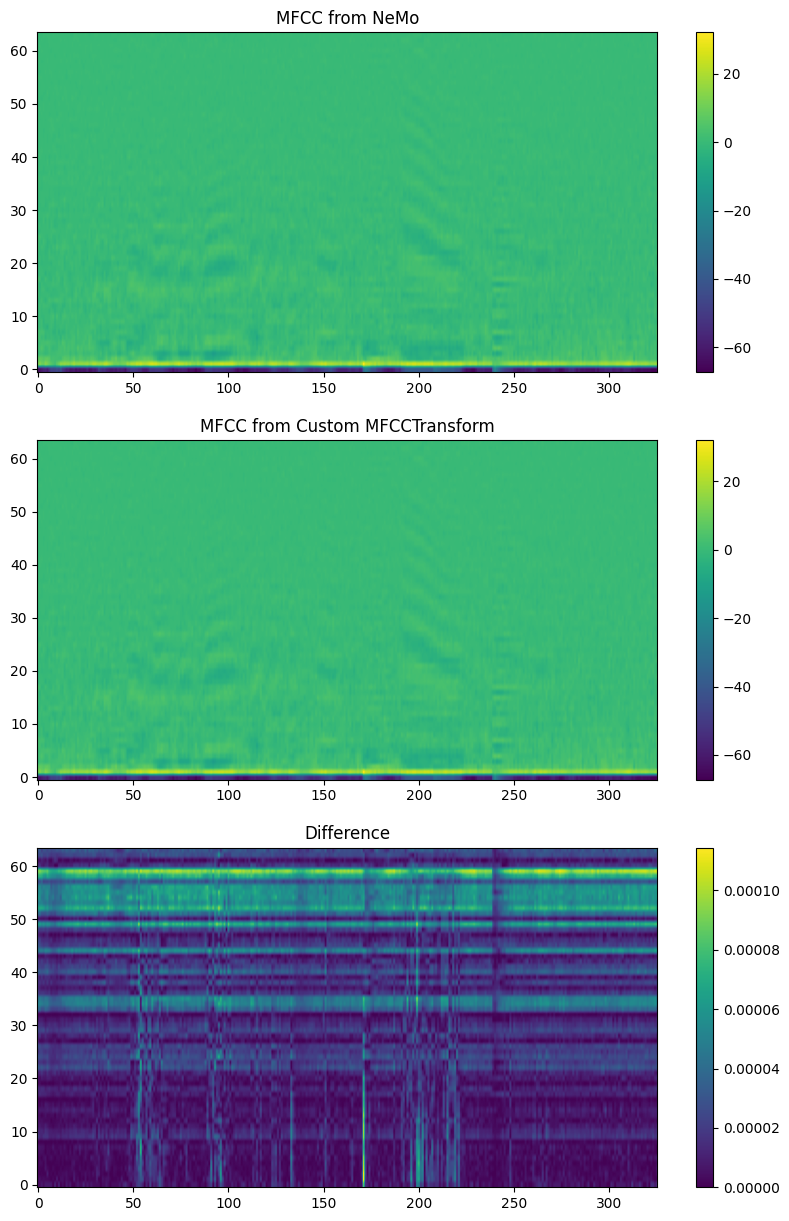

Mean absolute difference between MFCCs: 2.235806459793821e-05


In [46]:
# 두 MFCC 값 비교 함수
import matplotlib.pyplot as plt
def compare_mfcc(mfcc1, mfcc2):
    # MFCC 차이 계산
    difference = torch.abs(mfcc1 - mfcc2)
    print(difference)

    # 결과 시각화
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    im = axs[0].imshow(mfcc1.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title('MFCC from NeMo')
    fig.colorbar(im, ax=axs[0])

    im = axs[1].imshow(mfcc2.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axs[1].set_title('MFCC from Custom MFCCTransform')
    fig.colorbar(im, ax=axs[1])
    
    im = axs[2].imshow(difference.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axs[2].set_title('Difference')
    fig.colorbar(im, ax=axs[2])

    plt.show()

    # 평균 차이 출력
    mean_difference = torch.mean(difference)
    print(f"Mean absolute difference between MFCCs: {mean_difference.item()}")

# # NeMo 모델로부터 MFCC 추출 (이전에 계산한 nemo_mfcc 사용)
# nemo_mfcc = mfcc[0]

# # Custom MFCC 변환기를 사용하여 MFCC 추출
# custom_mfcc_model = MFCCTransform()
# waveform, sample_rate = torchaudio.load(file_path, normalize=True)
# waveform = waveform.unsqueeze(0)  # 배치 차원 추가
# custom_mfcc = custom_mfcc_model(waveform)
nemo_mfcc = nemo_mfcc.to('cpu')
# MFCC 비교
compare_mfcc(nemo_mfcc, output)

In [133]:
feature2= torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=64,
    dct_type=2,
    norm='ortho',
    log_mels=True,
    melkwargs={
        'f_min': 0.0,
        'f_max': None,
        'n_mels': 64,
        'n_fft': 2 ** math.ceil(math.log2(400)),
        'center': True,
        'pad_mode': 'reflect',
        'power': 2.0,
        'win_length': 400,
        'hop_length': 160,
        'window_fn': torch.hann_window,
        'mel_scale': 'htk',
        'norm': None,})

feature2=feature2.to(device)


In [ ]:
feature= torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=64,
    dct_type=2,
    norm='ortho',
    log_mels=True,
    melkwargs={
        'f_min': 0.0,
        'f_max': None,
        'n_mels': 64,
        'n_fft': 2 ** math.ceil(math.log2(400)),
        'win_length': 400,
        'hop_length': 160,
        'window_fn': torch.hann_window})

feature=feature.to(device)